In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import time

## Part 1 – Exploratory Data Analysis

The provided logins.json file includes simulated timestamps representing user login activity within a specific geographic area. Begin by grouping the login data into 15-minute intervals. Then, analyze the resulting time series by visualizing and interpreting the login counts to uncover patterns in user activity. Be sure to highlight notable trends such as daily or weekly usage cycles, and identify any potential issues with data quality.

To start, we'll aggregate the login data in 15-minute time bins, count the number of logins per interval, and generate plots that reflect both daily and weekly trends.

In [2]:
df_logins = pd.read_json('logins.json')
print(df_logins.info())
df_logins.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB
None


,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
df_logins.set_index('login_time', inplace=True)
df_logins['login_counts'] = np.ones(len(df_logins))
df_logins.head()

,login_counts
login_time,
1970-01-01 20:13:18,1.0
1970-01-01 20:16:10,1.0
1970-01-01 20:16:37,1.0
1970-01-01 20:16:36,1.0
1970-01-01 20:26:21,1.0


In [5]:
df_logins_15min = df_logins.resample('15T').sum()
df_logins_15min.head()

/var/folders/rs/tgtjg5z57zv1nf83v_yq3b7h0000gn/T/ipykernel_74719/584176625.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_logins_15min = df_logins.resample('15T').sum()


,login_counts
login_time,
1970-01-01 20:00:00,2.0
1970-01-01 20:15:00,6.0
1970-01-01 20:30:00,9.0
1970-01-01 20:45:00,7.0
1970-01-01 21:00:00,1.0


In [6]:
# Group login data into 15-minute intervals and calculate the sum of logins in each interval
login_counts_15min = df_logins.resample(rule='15min').agg('sum')

# Display the first few entries of the resampled DataFrame
login_counts_15min.head()

df_logins_15min['time'] = df_logins_15min.reset_index()['login_time'].dt.time.tolist()
df_logins_15min['day_of_week'] = df_logins_15min.reset_index()['login_time'].dt.dayofweek.tolist()
df_logins_15min['month'] = df_logins_15min.reset_index()['login_time'].dt.month.tolist()
df_logins_15min.reset_index(drop=True, inplace=True)
df_logins_15min.head()

,login_counts,time,day_of_week,month
0,2.0,20:00:00,3,1
1,6.0,20:15:00,3,1
2,9.0,20:30:00,3,1
3,7.0,20:45:00,3,1
4,1.0,21:00:00,3,1


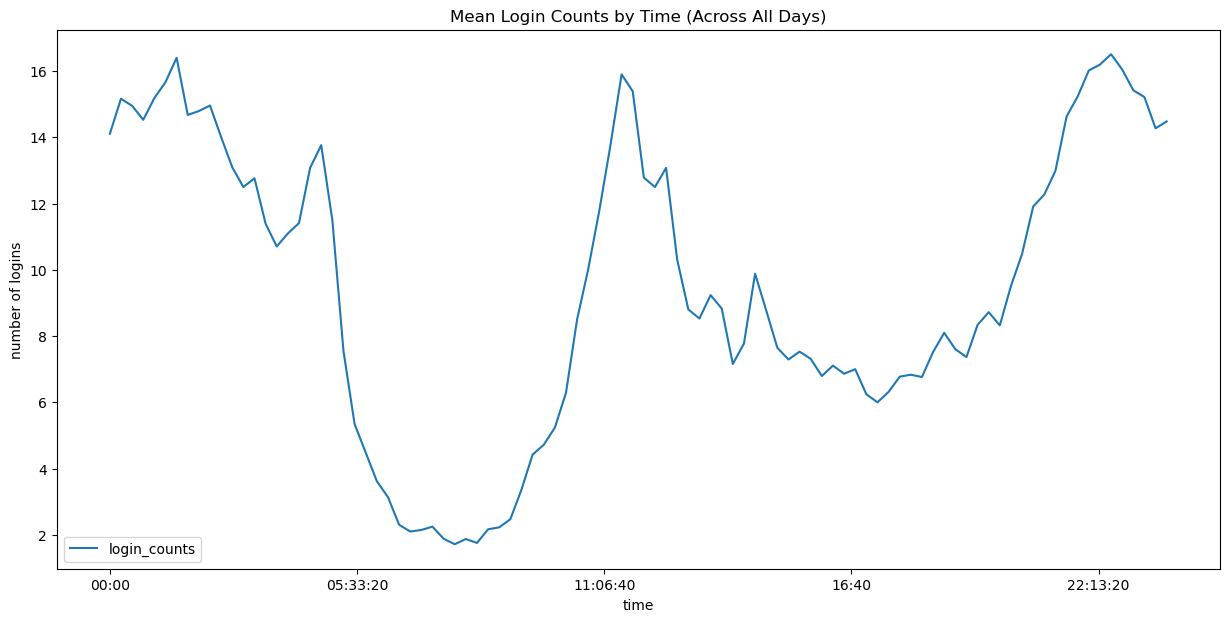

In [7]:
fig, ax = plt.subplots(figsize=(15,7))
df_logins_15min.groupby(['time']).mean().reset_index().plot(x='time', y='login_counts', ax=ax)
ax.set_ylabel('number of logins')
ax.set_title('Mean Login Counts by Time (Across All Days)')
plt.show()

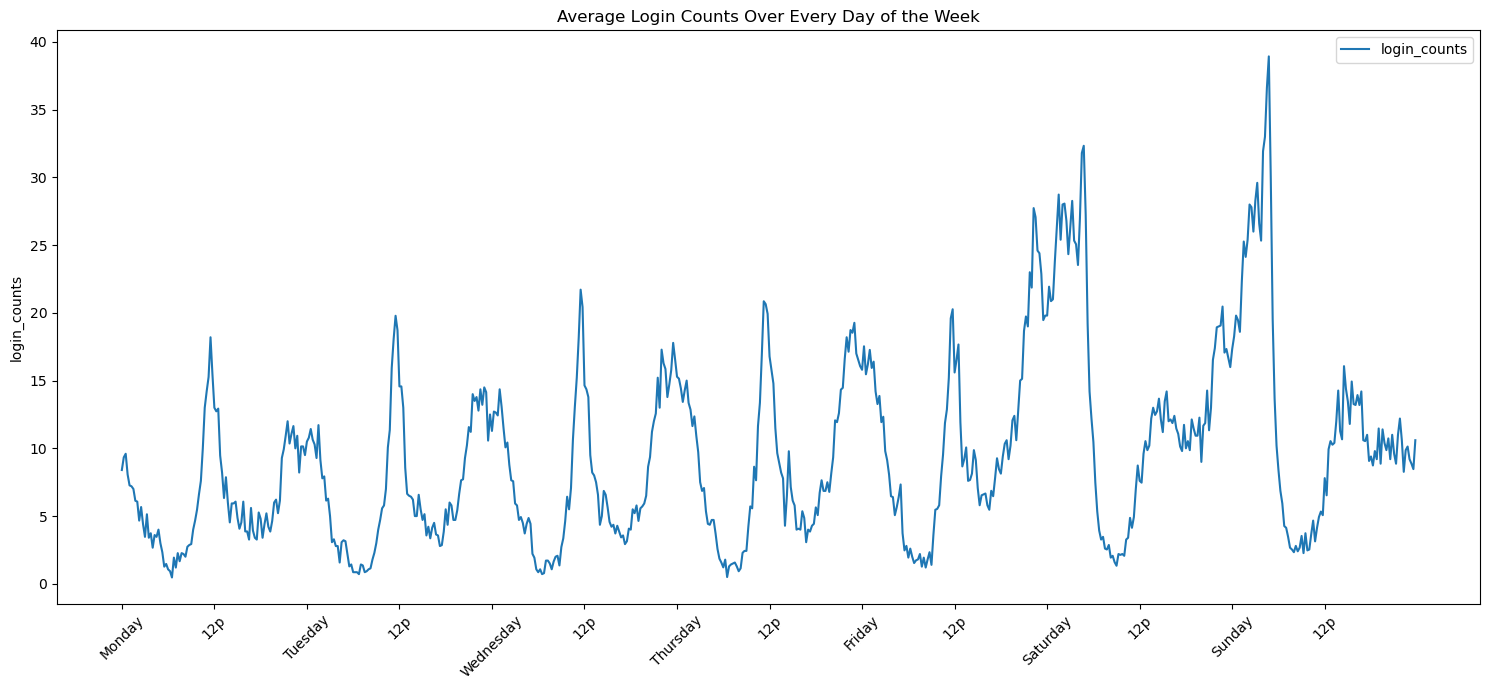

In [8]:
fig, ax = plt.subplots(figsize=(15,7))

# Group and plot
df_logins_15min.groupby(['day_of_week', 'time']).mean().reset_index().plot(y='login_counts', ax=ax)

# Define 14 tick positions (0 to 672 exclusive, step 48)
tick_positions = range(0, 672, int(672/14))  # 14 positions

# Corresponding 14 labels
tick_labels = ['Monday', '12p', 'Tuesday', '12p', 'Wednesday', '12p', 
               'Thursday', '12p', 'Friday', '12p', 'Saturday', '12p', 
               'Sunday', '12p']

ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=45)

ax.set_ylabel('login_counts')
ax.set_title('Average Login Counts Over Every Day of the Week')

plt.tight_layout()
plt.show()


In [9]:
# resample by day to count total daily average number of logins
df_logins_day = df_logins.resample('D').sum()
df_logins_day['day_of_week'] = df_logins.resample('D').sum().reset_index()['login_time'].dt.dayofweek.tolist()
df_logins_day.head()

,login_counts,day_of_week
login_time,,
1970-01-01,112.0,3
1970-01-02,681.0,4
1970-01-03,793.0,5
1970-01-04,788.0,6
1970-01-05,459.0,0


In [10]:
def visualize_logins_for_day(day_idx):
    """
    Generate a plot of login counts throughout the day specified by day_idx (0=Monday to 6=Sunday),
    and add an annotation showing the total average logins for that particular day.
    """
    plt.figure(figsize=(16, 8))
    
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    # Filter data for the selected day and aggregate login counts over time intervals
    daily_data = df_logins_15min.groupby(['day_of_week', 'time']).sum().loc[day_idx].reset_index()
    
    # Plot the login counts vs time for that day
    daily_data.plot(x='time', y='login_counts', legend=False)
    
    # Calculate the average total logins for this day over all records
    total_daily_sum = df_logins_day.groupby('day_of_week').sum().loc[day_idx]
    daily_occurrences = df_logins_day['day_of_week'].value_counts()[day_idx]
    avg_daily_total = int(total_daily_sum / daily_occurrences)
    
    # Position annotation near the minimum login count on y-axis
    y_pos = daily_data['login_counts'].min()
    plt.annotate(f'{day_names[day_idx]} avg total logins: {avg_daily_total}', 
                 xy=(0, 50), xytext=(60000, y_pos), fontsize=14)
    
    plt.title(day_names[day_idx])
    plt.ylabel('Login Count')
    plt.show()

/var/folders/rs/tgtjg5z57zv1nf83v_yq3b7h0000gn/T/ipykernel_74719/1227370503.py:19: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  avg_daily_total = int(total_daily_sum / daily_occurrences)


<Figure size 1600x800 with 0 Axes>

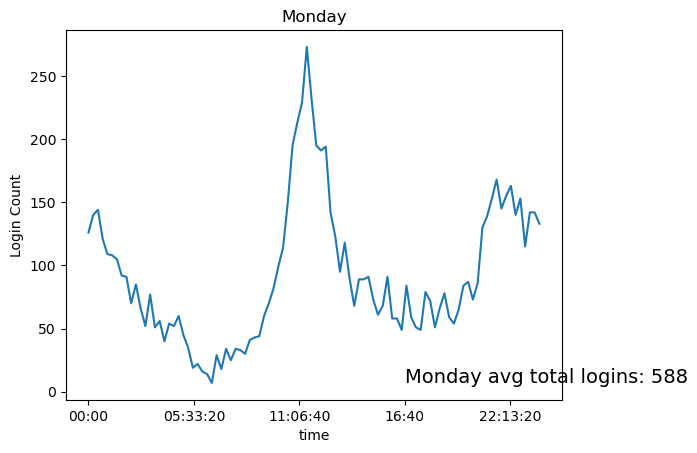

/var/folders/rs/tgtjg5z57zv1nf83v_yq3b7h0000gn/T/ipykernel_74719/1227370503.py:19: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  avg_daily_total = int(total_daily_sum / daily_occurrences)


<Figure size 1600x800 with 0 Axes>

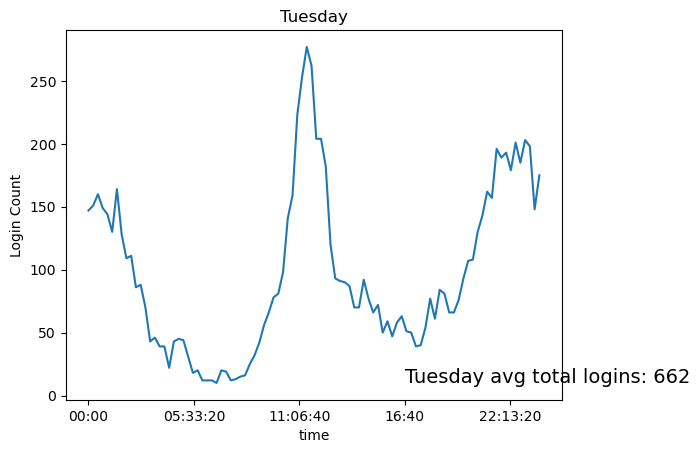

/var/folders/rs/tgtjg5z57zv1nf83v_yq3b7h0000gn/T/ipykernel_74719/1227370503.py:19: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  avg_daily_total = int(total_daily_sum / daily_occurrences)


<Figure size 1600x800 with 0 Axes>

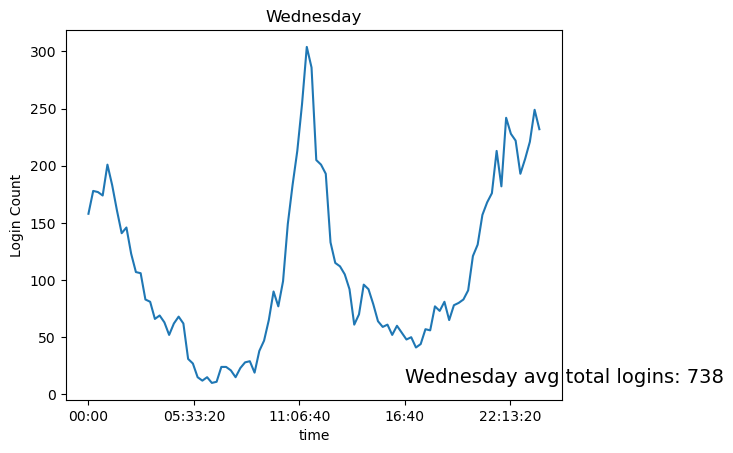

/var/folders/rs/tgtjg5z57zv1nf83v_yq3b7h0000gn/T/ipykernel_74719/1227370503.py:19: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  avg_daily_total = int(total_daily_sum / daily_occurrences)


<Figure size 1600x800 with 0 Axes>

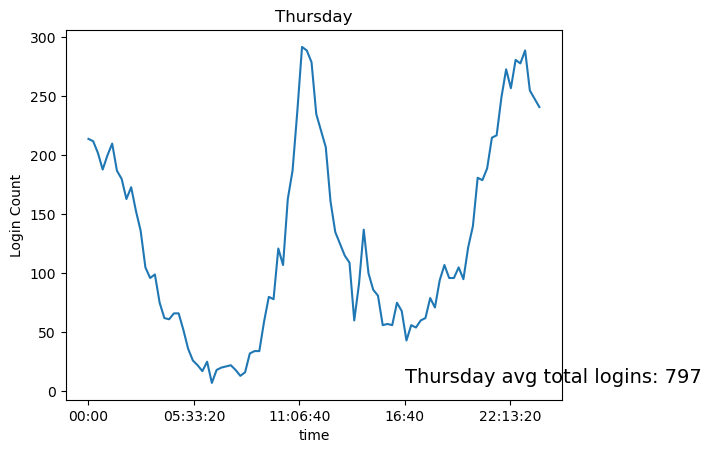

/var/folders/rs/tgtjg5z57zv1nf83v_yq3b7h0000gn/T/ipykernel_74719/1227370503.py:19: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  avg_daily_total = int(total_daily_sum / daily_occurrences)


<Figure size 1600x800 with 0 Axes>

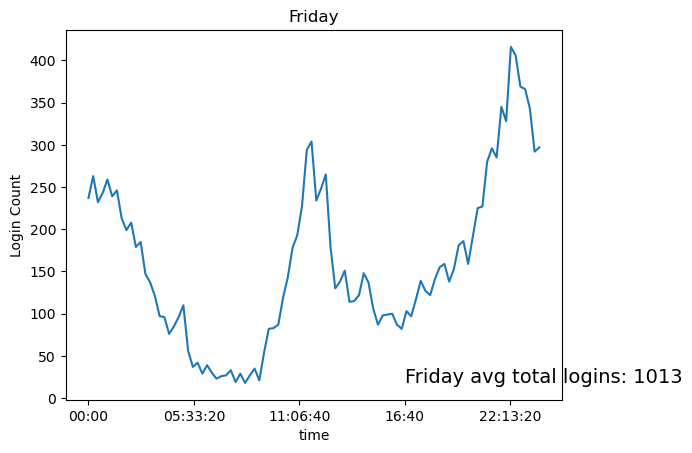

/var/folders/rs/tgtjg5z57zv1nf83v_yq3b7h0000gn/T/ipykernel_74719/1227370503.py:19: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  avg_daily_total = int(total_daily_sum / daily_occurrences)


<Figure size 1600x800 with 0 Axes>

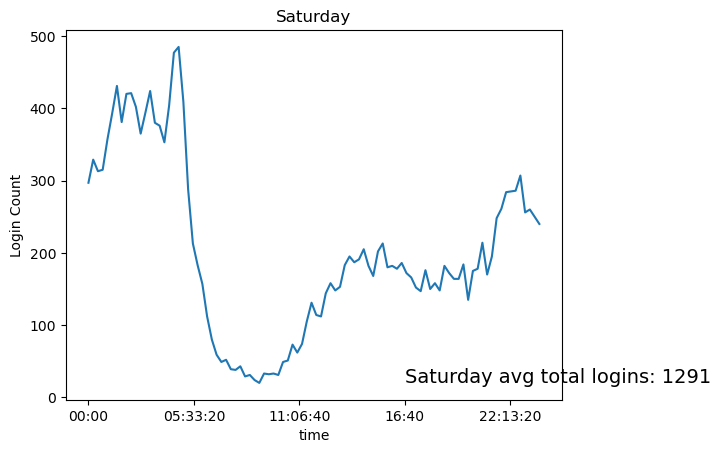

/var/folders/rs/tgtjg5z57zv1nf83v_yq3b7h0000gn/T/ipykernel_74719/1227370503.py:19: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  avg_daily_total = int(total_daily_sum / daily_occurrences)


<Figure size 1600x800 with 0 Axes>

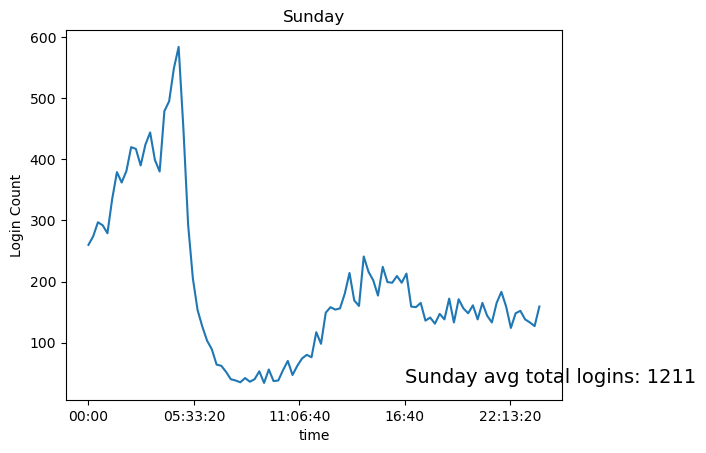

In [11]:
for i in range(7):
   visualize_logins_for_day(i)

The pattern of login counts across times of day remains fairly stable from Monday to Friday, showing peaks during late night/early morning and around midday. However, on weekends, the peak shifts to early morning and maintains a relatively steady level through the afternoon. Overall, the data appears clean and free of quality concerns.

## Part 2 – Designing the Experiment and Selecting Metrics

The neighboring cities, Gotham and Metropolis, exhibit opposite daily activity cycles: during weekdays, Gotham's peak activity occurs at night, while Metropolis is busiest during the day. On weekends, both cities experience moderate activity levels. However, the presence of a toll bridge connecting the two cities, which charges tolls in both directions, leads driver partners to predominantly operate exclusively in one city. To address this, the operations managers of both cities have proposed an experiment that reimburses all toll expenses, aiming to encourage drivers to serve both locations.

## Choosing a Key Success Metric

To evaluate the effectiveness of this experiment, I would focus on the average ratio of trips made by drivers in Gotham relative to those made in Metropolis. This metric directly reflects how balanced driver availability is across the two cities. A ratio close to 0.5 would indicate that drivers are serving both cities fairly equally, suggesting the toll reimbursement is having the intended effect.

## Experimental Design

To assess the impact of reimbursing tolls, I would collect data on the total number of trips completed by drivers before and after the initiative begins. Using this data, I would conduct an A/B hypothesis test where:

- The null hypothesis asserts that the toll reimbursement does not influence the ratio of trips between Gotham and Metropolis.

- The alternative hypothesis is that the initiative affects this ratio, encouraging more balanced service.

The required sample size and duration of the experiment would depend on factors including:

- The current baseline ratio of trips between the cities.

- The minimum change in the ratio that Ultimate Technologies wants to detect.

- Operational time constraints.

- The average daily volume of trips.

- A significance level set at 95%.

## Statistical Testing

After gathering the data, I would calculate the observed value of the ratio. Then, using permutation testing, I would simulate 10,000 randomized replicates of this test statistic by resampling the original data to estimate the null distribution. The p-value would be computed as the proportion of these replicates equal to or exceeding the observed ratio.

- If the p-value falls below 0.05, I would reject the null hypothesis and conclude there is a statistically significant effect of the toll reimbursement on driver availability across both cities.

- Otherwise, I would fail to reject the null, suggesting the initiative did not significantly change driver behavior.

## Considerations and Recommendations

Two important caveats apply:

- With a 95% confidence level, there remains a 5% chance that the test conclusions are incorrect.

- Statistical significance does not automatically imply practical or financial benefit. For instance, if the driver pool is small, the reimbursement might not justify the cost, especially during periods of low driver availability caused by external factors such as weather or bridge construction.

Overall, if the experiment yields a significant p-value and the costs of reimbursement are outweighed by increased profits from drivers serving both cities, I would recommend continuing the program. However, I would advise gathering additional information on trans-city trip volumes, overall trip demand, and the company's risk tolerance before making a final decision.

